In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from definitions import ROOT_DIR
from unc.utils import load_info

In [18]:
rg_path = Path(ROOT_DIR, 'results', 'rg')
rxg_path = Path(ROOT_DIR, 'results', 'rxg')
rpg_path = Path(ROOT_DIR, 'results', 'rpg')
rsg_path = Path(ROOT_DIR, 'results', 'rsg')

split_by = ['buffer_size', 'algo']

rg_color = 'black'
rxg_color = 'purple'
rsg_color = 'darkorange'
rpg_color = 'forestgreen'


def moving_avg(x, mode='valid', w=100):
    return np.convolve(x, np.ones(w), mode=mode) / w

In [19]:
def get_discounted_returns(ep_lengths, ep_rews, discount=0.99, maxlen=1000):
    assert ep_lengths.sum() == ep_rews.shape[0], f"Incompatible lengths and rews - lengths: {ep_lengths.sum()}, rews shape[0]: {ep_rews.shape[0]}"

    discounted_returns = []
    current_ep_disc_rew = 0
    idx = 0
    discounts = discount ** np.arange(maxlen)
    
    for ep_len in ep_lengths:
        curr_ep_rews = ep_rews[idx:idx + ep_len]
        current_ep_disc_rew = np.dot(curr_ep_rews, discounts[:ep_len])
        idx += ep_len
#         for i in range(ep_len):
#             current_ep_disc_rew += ep_rews[idx] * (discount ** i)
#             idx += 1
        discounted_returns.append(current_ep_disc_rew.astype(np.float32))
        current_ep_disc_rew = 0
    discounted_returns = np.array(discounted_returns)
    
    assert discounted_returns.shape[0] == ep_lengths.shape[0]
    
    return discounted_returns

In [20]:
def process_dir(dir_path, w=100, split_by=None, discount=0.99):
    if split_by is not None:
        all_results = {}
    else:
        all_results = []
        
    for f in dir_path.iterdir():
        info = load_info(f)
        args = info['args'].item()
        
        # We only consider prefilled here
        if args['p_prefilled'] == 0.:
            continue
        
        result = get_discounted_returns(info['episode_length'], info['reward'], discount)

        if split_by is not None:
            hparams = tuple(args[s] for s in split_by)
            split_by_tuple = tuple(split_by)
            if split_by_tuple not in all_results:
                all_results[split_by_tuple] = {}
            
            if hparams not in all_results[split_by_tuple]:
                all_results[split_by_tuple][hparams] = []
                
            all_results[split_by_tuple][hparams].append((info['episode_length'], result))
            
        else:
            all_results.append((info['episode_length'], result))
            
#     if split_by is not None:
#         for k, v in all_results.items():
#             for k1, v1 in v.items():
#                 all_results[k][k1] = np.array(all_results[k][k1])
#         data = all_results
#     else:
#         data = np.array(all_results)

    
    return all_results


In [21]:
discount = 0.99
rg_data = process_dir(rg_path, split_by=split_by, discount=discount)
rxg_data = process_dir(rxg_path, split_by=split_by, discount=discount)
rpg_data = process_dir(rpg_path, split_by=split_by, discount=discount)
rsg_data = process_dir(rsg_path, split_by=split_by, discount=discount)

In [22]:
# we average the discounted episodic rewards over the final 100 episodes.

def get_eps_max_over(data, eps_max_over=100):
    hparam_results = []
    for args, all_dis_rew in data[tuple(split_by)].items():
        final_max = np.mean([np.mean(dis_rew[-100:]) for length, dis_rew in all_dis_rew])
        hparam_results.append((args, final_max))
    return hparam_results


In [23]:
eps_max_over = 100
rg_max_over = get_eps_max_over(rg_data, eps_max_over)
rxg_max_over = get_eps_max_over(rxg_data, eps_max_over)
rpg_max_over = get_eps_max_over(rpg_data, eps_max_over)
rsg_max_over = get_eps_max_over(rsg_data, eps_max_over)

In [24]:
# Get the best hyperparams based on the final 100 episodes
rg_best = sorted(rg_max_over, key=lambda x : x[1], reverse=True)[0]
rxg_best = sorted(rxg_max_over, key=lambda x : x[1], reverse=True)[0]
rpg_best = sorted(rpg_max_over, key=lambda x : x[1], reverse=True)[0]
rsg_best = sorted(rsg_max_over, key=lambda x : x[1], reverse=True)[0]

rg_best, rxg_best, rpg_best, rsg_best

(((10000, 'sarsa'), 11.351726046131535),
 ((100000, 'sarsa'), 15.56115201086564),
 ((20000, 'sarsa'), 30.389175507111986),
 ((20000, 'esarsa'), 42.22665785264854))

In [25]:
# Now we map our discounted episodic rewards back to steps. We assign the discounted reward achieved at the 
# end of and episode to each timestep within the episode


def map_dis_rew_to_steps(data, w=1000):
    all_seeds = []
    for lengths, dis_rews in data:
        current_seed = []
        for length, dis_rew in zip(lengths, dis_rews):
            current_seed.append(np.zeros(length) + dis_rew)
        all_seeds.append(moving_avg(np.concatenate(current_seed)[:trunc], w=w))
    return np.array(all_seeds)

In [26]:
trunc = int(5e5)

rg_best_data = rg_data[tuple(split_by)][rg_best[0]]
rxg_best_data = rxg_data[tuple(split_by)][rxg_best[0]]
rpg_best_data = rpg_data[tuple(split_by)][rpg_best[0]]
rsg_best_data = rsg_data[tuple(split_by)][rsg_best[0]]

mapped_rg = map_dis_rew_to_steps(rg_best_data)
mapped_rxg = map_dis_rew_to_steps(rxg_best_data)
mapped_rpg = map_dis_rew_to_steps(rpg_best_data)
mapped_rsg = map_dis_rew_to_steps(rsg_best_data)

In [27]:
all_data = [
    ('Normal obs', mapped_rg, rg_color),
    ('Ground-truth check obs', mapped_rxg, rxg_color),
    ('PF obs', mapped_rpg, rpg_color),
    ('Ground-truth position obs', mapped_rsg, rsg_color)
]

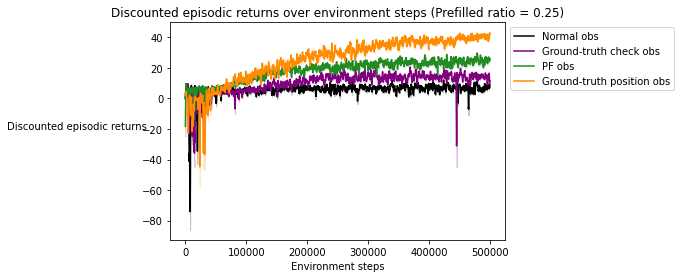

In [28]:
x = np.arange(mapped_rg.shape[1])
fig, ax = plt.figure(), plt.axes()


for key, data, color in all_data:
    means = data.mean(axis=0)
    std_err = data.std(axis=0) / data.shape[0]

    ax.plot(x, means, label=key, color=color)
    plt.fill_between(x, means - std_err, means + std_err,
                         color=color, alpha=0.2)

ax.set_xlabel('Environment steps')
ax.set_ylabel(f"Discounted episodic returns", rotation=0, labelpad=65)
ax.set_title(f'Discounted episodic returns over environment steps (Prefilled ratio = 0.25)')
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left')
